In [10]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from datetime import datetime

%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
class RemoveFirstFrame(BaseEstimator, TransformerMixin):
    def __init__(self, frame):
        self.frame = frame
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.query(f"Step % {frame} != 1")

In [23]:
raw_test_data = pd.read_csv("/Users/weilu/Research/data/test_data/test_data_4.csv")
raw_test_data_2 = raw_test_data.drop_duplicates(subset=['Qw', 'Rw', "VTotal"])
raw_test_data_2 = raw_test_data_2.assign(isGood=raw_test_data_2.groupby("Name")["GDT"].rank(ascending=False, method='first') < 50)
raw_test_data = raw_test_data_2
raw_data_T0784 = raw_test_data.groupby("Name").get_group("T0784")
raw_data_T0792 = raw_test_data.groupby("Name").get_group("T0792")
# raw_data = pd.concat([raw_data_T0784, raw_data_T0792])
raw_data = raw_data_T0792


# FEATURES = ["Rw", "VTotal", "QGO"]
# FEATURES = ["Rw", "VTotal", "QGO", "Burial", "Frag_Mem", "Water"]
# FEATURES = list(raw_test_data.columns[2:-3])
FEATURES = ['Rw',
 'VTotal',
 'QGO',
 'Burial',
 'Water',
 'Rama',
 'DSSP',
 'P_AP',
 'Helix',
 'Frag_Mem']
# LABEL = "Qw"
LABEL = "isGood"
PolynomialDegree = 1
p = 0.1

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
class RemoveFirstFrame(BaseEstimator, TransformerMixin):
    def __init__(self, frame):
        self.frame = frame
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.query(f"Step % {frame} != 1")
    
num_attribs = FEATURES
cat_attribs = [LABEL]
frame = 201
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs))
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
my_full_pipeline = Pipeline([
#         ('removeFirstFrame', RemoveFirstFrame(frame)),
        ('featureSelection', full_pipeline)
])
    
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(raw_data, raw_data["isGood"]):
    strat_train_set = raw_data.iloc[train_index]
    strat_test_set = raw_data.iloc[test_index]
# strat_test_set[LABEL].value_counts() / len(strat_test_set)
X_train = my_full_pipeline.fit_transform(strat_train_set)
X_test = my_full_pipeline.fit_transform(strat_test_set)
train_y = X_train[:,-1]
train_set = X_train[:,:-1]
test_y = X_test[:,-1]
test_set = X_test[:,:-1]


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# log_clf = LogisticRegression(random_state=142)
# rnd_clf = RandomForestClassifier(random_state=432)
# svm_clf = SVC(probability=True, random_state=412)
log_clf = LogisticRegression(random_state=142, class_weight={0:p, 1:(1-p)})
rnd_clf = RandomForestClassifier(random_state=432, class_weight={0:p, 1:(1-p)})
svm_clf = SVC(probability=True, random_state=412, class_weight={0:p, 1:(1-p)})

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
log_clf.fit(train_set, train_y)
rnd_clf.fit(train_set, train_y)
svm_clf.fit(train_set, train_y)
voting_clf.fit(train_set, train_y)


# check on training set
n = 10
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
#     y_pred = clf.predict(train_set)
    prob= clf.predict_proba(train_set)[:,1]
    position_of_top_n = prob.argsort()[-n:][::-1]
    threshold = prob[position_of_top_n][-1]
    predict_y = np.zeros(len(train_y),)
    predict_y[position_of_top_n] = 1
#     predict_y = (test > threshold)
#     print(threshold)
    cm = confusion_matrix(train_y, predict_y)
#     print(clf.__class__.__name__, "\n", accuracy_score(train_y, predict_y))
    print(clf.__class__.__name__, "\n", cm)
    
time_stamp = f"{datetime.today().strftime('%d_%h_%H%M%S')}"
for name, data in raw_test_data.groupby("Name"):
    print(name)
    X = full_pipeline.fit_transform(data)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    position_of_top_n = test.argsort()[-n:][::-1]
    threshold = test[position_of_top_n][-1]
    predict_y = np.zeros(len(eval_y),)
    predict_y[position_of_top_n] = 1

    with open(f"/Users/weilu/Research/data/structure_selector/p{p}_poly{PolynomialDegree}_{name}.csv", "w") as f:
        f.write("Result\n")
        for i in test:
            f.write(str(i) + "\n")
#     with open(f"/Users/weilu/Research/data/structure_selector/{name}_results_{time_stamp}.csv", "w") as f:
#         f.write("Result\n")
#         for i in test:
#             f.write(str(i) + "\n")

#     predict_y = (test > threshold)
#     print(threshold)
    print(confusion_matrix(eval_y, predict_y))
print(f"p{p}_poly{PolynomialDegree}")

LogisticRegression 
 [[1555    6]
 [  35    4]]
RandomForestClassifier 
 [[1561    0]
 [  29   10]]
SVC 
 [[1557    4]
 [  33    6]]
VotingClassifier 
 [[1561    0]
 [  29   10]]
1MBA
[[1944    8]
 [  47    2]]
T0766
[[1946    6]
 [  45    4]]
T0784
[[1942   10]
 [  49    0]]
T0792
[[1948    4]
 [  43    6]]
T0803
[[1944    8]
 [  47    2]]
T0815
[[1946    6]
 [  45    4]]
T0833
[[1915    9]
 [  48    1]]
T251
[[1943    9]
 [  48    1]]
p0.1_poly1


In [12]:
raw_test_data = pd.read_csv("/Users/weilu/Research/data/test_data/test_data_4.csv")
raw_test_data_2 = raw_test_data.drop_duplicates(subset=['Qw', 'Rw', "VTotal"])
raw_test_data_2 = raw_test_data_2.assign(isGood=raw_test_data_2.groupby("Name")["GDT"].rank(ascending=False, method='first') < 50)
raw_test_data = raw_test_data_2
raw_data_T0784 = raw_test_data.groupby("Name").get_group("T0784")
raw_data_T0792 = raw_test_data.groupby("Name").get_group("T0792")
# raw_data = pd.concat([raw_data_T0784, raw_data_T0792])
raw_data = raw_data_T0792

In [26]:
# FEATURES = ["Rw", "VTotal", "QGO"]
# FEATURES = ["Rw", "VTotal", "QGO", "Burial", "Frag_Mem", "Water"]
# FEATURES = list(raw_test_data.columns[2:-3])
FEATURES = ['Rw',
 'VTotal',
 'QGO',
 'Burial',
 'Water',
 'Rama',
 'DSSP',
 'P_AP',
 'Helix',
 'Frag_Mem']
# LABEL = "Qw"
LABEL = "isGood"
PolynomialDegree = 2
p = 0.1


num_attribs = FEATURES
cat_attribs = [LABEL]
frame = 201
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs))
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
my_full_pipeline = Pipeline([
#         ('removeFirstFrame', RemoveFirstFrame(frame)),
        ('featureSelection', full_pipeline)
])
    
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(raw_data, raw_data["isGood"]):
    strat_train_set = raw_data.iloc[train_index]
    strat_test_set = raw_data.iloc[test_index]
# strat_test_set[LABEL].value_counts() / len(strat_test_set)
X_train = my_full_pipeline.fit_transform(strat_train_set)
X_test = my_full_pipeline.fit_transform(strat_test_set)
train_y = X_train[:,-1]
train_set = X_train[:,:-1]
test_y = X_test[:,-1]
test_set = X_test[:,:-1]



# log_clf = LogisticRegression(random_state=142)
# rnd_clf = RandomForestClassifier(random_state=432)
# svm_clf = SVC(probability=True, random_state=412)
log_clf = LogisticRegression(random_state=142, class_weight={0:p, 1:(1-p)})

log_clf.fit(train_set, train_y)


# check on training set
n = 5

clf = log_clf
#     y_pred = clf.predict(train_set)
prob= clf.predict_proba(train_set)[:,1]
position_of_top_n = prob.argsort()[-n:][::-1]
threshold = prob[position_of_top_n][-1]
predict_y = np.zeros(len(train_y),)
predict_y[position_of_top_n] = 1
#     predict_y = (test > threshold)
#     print(threshold)
cm = confusion_matrix(train_y, predict_y)
#     print(clf.__class__.__name__, "\n", accuracy_score(train_y, predict_y))
print(clf.__class__.__name__, "\n", cm)



for name, data in raw_test_data.groupby("Name"):
    print(name)
    X = full_pipeline.fit_transform(data)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    position_of_top_n = test.argsort()[-n:][::-1]
    threshold = test[position_of_top_n][-1]
    predict_y = np.zeros(len(eval_y),)
    predict_y[position_of_top_n] = 1
    print(confusion_matrix(eval_y, predict_y))
print(f"p{p}_poly{PolynomialDegree}")



LogisticRegression 
 [[1559    2]
 [  36    3]]
1MBA
[[1947    5]
 [  49    0]]
T0766
[[1947    5]
 [  49    0]]
T0784
[[1947    5]
 [  49    0]]
T0792
[[1949    3]
 [  47    2]]
T0803
[[1947    5]
 [  49    0]]
T0815
[[1949    3]
 [  47    2]]
T0833
[[1919    5]
 [  49    0]]
T251
[[1947    5]
 [  49    0]]
p0.1_poly2


In [46]:
strat_train_set["a"] = prob

/Users/weilu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


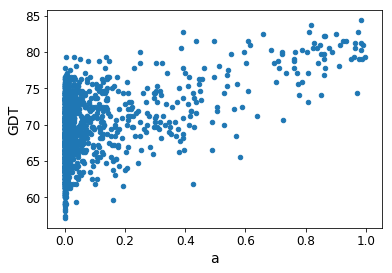

In [49]:
strat_train_set.plot("a", "GDT", kind="scatter")

In [45]:
prob

array([  1.16491821e-11,   3.72178125e-02,   1.06612780e-01, ...,
         4.89392979e-03,   2.67241498e-05,   2.70575860e-03])

In [43]:
pd.concat([strat_train_set, pd.Series(prob)], axis=1)

,Step,Qw,Rw,VTotal,QGO,Burial,Water,Rama,Chain,Chi,DSSP,P_AP,Helix,Frag_Mem,GDT,Name,Good,isGood,0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.164918e-11
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.721781e-02
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.066128e-01
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.563204e-04
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.127779e-03
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.576430e-02
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.272314e-03
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.276116e-02
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.763054e-03
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.304295e-03


In [32]:
def compute_with_my_score_function(p=0.9, PolynomialDegree=3):
    FEATURES = ['Rw',
     'VTotal',
     'QGO',
     'Burial',
     'Water',
     'Rama',
     'DSSP',
     'P_AP',
     'Helix',
     'Frag_Mem']
    # LABEL = "Qw"
    LABEL = "isGood"

    num_attribs = FEATURES
    cat_attribs = [LABEL]
    frame = 201
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    cat_pipeline = Pipeline([
            ('selector', DataFrameSelector(cat_attribs))
        ])

    full_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline),
        ])
    my_full_pipeline = Pipeline([
    #         ('removeFirstFrame', RemoveFirstFrame(frame)),
            ('featureSelection', full_pipeline)
    ])

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(raw_data, raw_data["isGood"]):
        strat_train_set = raw_data.iloc[train_index]
        strat_test_set = raw_data.iloc[test_index]
    # strat_test_set[LABEL].value_counts() / len(strat_test_set)
    X_train = my_full_pipeline.fit_transform(strat_train_set)
    X_test = my_full_pipeline.fit_transform(strat_test_set)
    train_y = X_train[:,-1]
    train_set = X_train[:,:-1]
    test_y = X_test[:,-1]
    test_set = X_test[:,:-1]

    # log_clf = LogisticRegression(random_state=142)
    # rnd_clf = RandomForestClassifier(random_state=432)
    # svm_clf = SVC(probability=True, random_state=412)
    log_clf = LogisticRegression(random_state=142, class_weight={0:p, 1:(1-p)})
    log_clf.fit(train_set, train_y)

#     voting_clf.fit(train_set, train_y)
    n = 10
    cl_name = "lr"
    clf = log_clf
#     for cl_name, clf in ("voting", voting_clf):
    my_evaluation = 1.0
    another_evaluation = 0.0
    for name, data in raw_test_data.groupby("Name"):
#             print(name)
#         X = full_pipeline.fit_transform(data)
#         validation_data, test_data = train_test_split(X, test_size=0.6, random_state=124)
        validation_data = my_full_pipeline.fit_transform(raw_data_T0784)
        validation_y = validation_data[:,-1]
        validation_set = validation_data[:,:-1]
        clf.fit(train_set, train_y)
        test= clf.predict_proba(validation_set)[:,1]
        position_of_top_n = test.argsort()[-n:][::-1]
        threshold = test[position_of_top_n][-1]
        predict_y = np.zeros(len(validation_y),)
        predict_y[position_of_top_n] = 1
    #     predict_y = (test > threshold)
#         print(threshold)
        cm = confusion_matrix(validation_y, predict_y)
#             print(cm)
        precision = cm[1][1] / (cm[1][1] + cm[0][1])
#             print(name,  " precision", precision,end = " ")
        if name != "T0766" and name != "T0833":
            my_evaluation *= precision
            another_evaluation += precision
#         print("")
    print("classifier:", cl_name, ", p:",p, ", degree", PolynomialDegree, ", score", my_evaluation, ", another score", another_evaluation)
    return (cl_name, p, PolynomialDegree, my_evaluation)

In [34]:
def myGridSerach():
    p_list = [0.9, 0.8, 0.7, 0.5, 0.1]
    degree_list = [3, 2, 1]
#     p_list = [0.1, 0.8, 0.9, 0.95]
#     degree_list = [1, 2, 3]
#     p_list = [0.1, 0.15, 0.2, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95]
#     degree_list = [1, 2, 3, 4]
    result = []
    for p in p_list:
        for degree in degree_list:
            result += [compute_with_my_score_function(p, degree)]
            

In [35]:
myGridSerach()

classifier: lr , p: 0.9 , degree 3 , score 1e-06 , another score 0.6
classifier: lr , p: 0.9 , degree 2 , score 0.0 , another score 0.0
classifier: lr , p: 0.9 , degree 1 , score 0.0 , another score 0.0
classifier: lr , p: 0.8 , degree 3 , score 1e-06 , another score 0.6
classifier: lr , p: 0.8 , degree 2 , score 0.0 , another score 0.0
classifier: lr , p: 0.8 , degree 1 , score 0.0 , another score 0.0
classifier: lr , p: 0.7 , degree 3 , score 0.0 , another score 0.0
classifier: lr , p: 0.7 , degree 2 , score 0.0 , another score 0.0
classifier: lr , p: 0.7 , degree 1 , score 0.0 , another score 0.0
classifier: lr , p: 0.5 , degree 3 , score 0.0 , another score 0.0
classifier: lr , p: 0.5 , degree 2 , score 0.0 , another score 0.0
classifier: lr , p: 0.5 , degree 1 , score 0.0 , another score 0.0
classifier: lr , p: 0.1 , degree 3 , score 0.0 , another score 0.0
classifier: lr , p: 0.1 , degree 2 , score 0.0 , another score 0.0
classifier: lr , p: 0.1 , degree 1 , score 0.0 , another s

In [33]:
compute_with_my_score_function(0.1, 1)

classifier: lr , p: 0.1 , degree 1 , score 0.0 , another score 0.0


('lr', 0.1, 1, 0.0)

In [185]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
class RemoveFirstFrame(BaseEstimator, TransformerMixin):
    def __init__(self, frame):
        self.frame = frame
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.query(f"Step % {frame} != 1")

In [186]:
num_attribs = FEATURES
cat_attribs = [LABEL]
frame = 201
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs))
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
my_full_pipeline = Pipeline([
#         ('removeFirstFrame', RemoveFirstFrame(frame)),
        ('featureSelection', full_pipeline)
])

In [187]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(raw_data, raw_data["isGood"]):
    strat_train_set = raw_data.iloc[train_index]
    strat_test_set = raw_data.iloc[test_index]
# strat_test_set[LABEL].value_counts() / len(strat_test_set)
X_train = my_full_pipeline.fit_transform(strat_train_set)
X_test = my_full_pipeline.fit_transform(strat_test_set)
train_y = X_train[:,-1]
train_set = X_train[:,:-1]
test_y = X_test[:,-1]
test_set = X_test[:,:-1]

In [188]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# log_clf = LogisticRegression(random_state=142)
# rnd_clf = RandomForestClassifier(random_state=432)
# svm_clf = SVC(probability=True, random_state=412)
log_clf = LogisticRegression(random_state=142, class_weight={0:p, 1:(1-p)})
rnd_clf = RandomForestClassifier(random_state=432, class_weight={0:p, 1:(1-p)})
svm_clf = SVC(probability=True, random_state=412, class_weight={0:p, 1:(1-p)})

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
log_clf.fit(train_set, train_y)
rnd_clf.fit(train_set, train_y)
svm_clf.fit(train_set, train_y)
voting_clf.fit(train_set, train_y)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight={0: 0.1, 1: 0.9}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=142,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)), ('r...f',
  max_iter=-1, probability=True, random_state=412, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [189]:
# check on training set
n = 10
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
#     y_pred = clf.predict(train_set)
    prob= clf.predict_proba(train_set)[:,1]
    position_of_top_n = prob.argsort()[-n:][::-1]
    threshold = prob[position_of_top_n][-1]
    predict_y = np.zeros(len(train_y),)
    predict_y[position_of_top_n] = 1
#     predict_y = (test > threshold)
#     print(threshold)
    cm = confusion_matrix(train_y, predict_y)
#     print(clf.__class__.__name__, "\n", accuracy_score(train_y, predict_y))
    print(clf.__class__.__name__, "\n", cm)

LogisticRegression 
 [[1558    4]
 [  32    6]]
RandomForestClassifier 
 [[1562    0]
 [  28   10]]
SVC 
 [[1559    3]
 [  31    7]]
VotingClassifier 
 [[1561    1]
 [  29    9]]


In [190]:
time_stamp = f"{datetime.today().strftime('%d_%h_%H%M%S')}"
for name, data in raw_test_data.groupby("Name"):
    print(name)
    X = full_pipeline.fit_transform(data)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    position_of_top_n = test.argsort()[-n:][::-1]
    threshold = test[position_of_top_n][-1]
    predict_y = np.zeros(len(eval_y),)
    predict_y[position_of_top_n] = 1

    with open(f"/Users/weilu/Research/data/structure_selector/p{p}_poly{PolynomialDegree}_{name}.csv", "w") as f:
        f.write("Result\n")
        for i in test:
            f.write(str(i) + "\n")
#     with open(f"/Users/weilu/Research/data/structure_selector/{name}_results_{time_stamp}.csv", "w") as f:
#         f.write("Result\n")
#         for i in test:
#             f.write(str(i) + "\n")

#     predict_y = (test > threshold)
#     print(threshold)
    print(confusion_matrix(eval_y, predict_y))

1MBA
[[1942    9]
 [  49    1]]
T0766
[[1943    9]
 [  48    1]]
T0784
[[1939   10]
 [  52    0]]
T0792
[[1950    4]
 [  41    6]]
T0803
[[1943    9]
 [  48    1]]
T0815
[[1945    9]
 [  46    1]]
T0833
[[1914   10]
 [  49    0]]
T251
[[1940   10]
 [  51    0]]


In [180]:
time_stamp = f"{datetime.today().strftime('%d_%h_%H%M%S')}"
for name, data in raw_test_data.groupby("Name"):
    print(name)
    X = my_full_pipeline.fit_transform(data)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    position_of_top_n = test.argsort()[-n:][::-1]
    threshold = test[position_of_top_n][-1]
    predict_y = np.zeros(len(eval_y),)
    predict_y[position_of_top_n] = 1


#     predict_y = (test > threshold)
#     print(threshold)
    print(confusion_matrix(eval_y, predict_y))

1MBA
[[1943    8]
 [  48    2]]
T0766
[[1946    6]
 [  45    4]]
T0784
[[1939   10]
 [  52    0]]
T0792
[[1949    5]
 [  42    5]]
T0803
[[1944    8]
 [  47    2]]
T0815
[[1946    8]
 [  45    2]]
T0833
[[1915    9]
 [  48    1]]
T251
[[1941    9]
 [  50    1]]
